# IVADO Workshop on Recommender Systems

# Matrix Factorization

## Authors: 

David Berger (davidberger2785 [at] gmail [dot] com)

Laurent Charlin (lcharlin [at] gmail [dot] com)

Nissan Pow (nissan [dot] pow [at] gmail [dot] com)

Dora Jambor (dorajambor [at] gmail [dot] com)

# 1. Introduction

This workshop is an introduction to recommender systems. Specifically, we propose to first implement a recommender system based on matrix factorization. Since this type of architecture is strongly associated with the <a href="https://en.wikipedia.org/wiki/Netflix_Prize">Netflix Prize</a>, we will use the <a href="https://grouplens.org/datasets/movielens/">MovieLens</a> dataset to train our models and conduct experiments.

## 1.2 Installing libraries

Before we begin, we must make sure to install the libraries for the tutorial using `pip`. To do this, run the following cell by selecting it and clicking `shift`+`Enter`.

In [4]:
!rm -rf RS-Workshop
!git clone https://github.com/davidberger2785/RS-Workshop

Cloning into 'RS-Workshop'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 49 (delta 14), reused 47 (delta 12), pack-reused 0
Unpacking objects: 100% (49/49), done.


To ensure that the installation has taken place, import all the libraries and modules we will use for this workshop by running the next cell.

In [9]:
import numpy as np
import pandas as pd

# Data vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# Homemade functions
sys.path += ['RS-Workshop/Tutoriels - En/']
import utilities as utl

We have also coded some boilerplate functions that we have grouped together in the `utilities` library. In fact, these functions probably already exist in python, but we simply ignore thier existence ...

In [10]:
ls

RS-Workshop/  sample_data/


## 1.1 Goal

The purpose of recommender systems is, as the name implies, to make personalized recommendations. Ideally, these recommendations will have to be good, although this concept seems fuzzy. Unlike other tasks in machine learning, such as the cats images recognition or stock market predictions, making recommendations to help a user is more complex. Is the aim to present a specific user with suggestions that reinforce her previous choices? Do we want to present complementary or totally independent suggestions for the items previously considered? Will we try instead to present her items to which she has not yet been exposed? Each of these options are correct and can be modeled. Without loss of generality, the diagram below simply models the issue of recommendation systems from the perspective of machine learning.

<img src = "../Images/High_level_1.png" width = "500">

Nevertheless, in the context of this workshop, that is, either the suggestion of movies on streaming platforms such as Netflix or Amazon Prime, we can reduce the problem to a relatively simple task: recommend movies that the user will like according to her past interests. In order to carry out this task, we will use all the preferences of the users, certain associated sociodemographic variables as well as certain characteristics of the movies. Finally, we can refine the diagram as follows:

<img src = "RS-Workshop/Images/High_level_2.png" width = "750">

## 1.3 The MoviesLens dataset(s)

The data used here consist of more or less 100k movie evaluations by 943 users. Over 1,6k movies are available. In addition to the 100k evaluations, additional information related to users and movies is available.

We will use three different datasets to carry out our analyses:

<ul>
<li> Users : related to users' characteristics,
<li> Movies : related to movies' characteristics,
<li> Ratings : containing over 100k evaluations.
</ul>

We used the <a href="https://pandas.pydata.org/">Pandas</a> library in order to download and manipulate the datasets.

### 1.3.1 Users: Download and preprocessing

In [3]:
# Download
ROOT_DIR = 'RS-Workshop/'
DATA_DIR = os.path.join(ROOT_DIR, 'data/ml-100k/')

users = pd.read_csv(os.path.join(DATA_DIR, 'u.user'), 
                        sep='|', header=None, engine='python', encoding='latin-1')

# Different variables according to the information provided in the readme file
users.columns = ['Index', 'Age', 'Gender', 'Occupation', 'Zip code']

# Quick overview
users.head()

,Index,Age,Gender,Occupation,Zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
print('Number of users x features:', users.shape)

Number of users x features: (943, 5)


Before presenting some descriptive statistics related to the population, we transform the users' data in a <a href="https://en.wikipedia.org/wiki/List_(abstract_data_type)">list</a> in order to be able to handle them more easily. The occupation of each user is a string, so we have recoded the 21 possible occupations in Boolean.

In [ ]:
# Number of users
nb_users = len(users)

# Gender: Convert 'M' and 'F' to 0 and 1
gender = np.where(np.matrix(users['Gender']) == 'M', 0, 1)[0]

print('Shape of gender features:', gender.shape)

# Occupation
occupation_name = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u.occupation'), 
                                            sep='|', header=None, engine='python', encoding='latin-1').loc[:, 0])

# Boolean transformation of user's occupation
occupation_matrix = np.zeros((nb_users, len(occupation_name)))

for k in np.arange(nb_users):
    occupation_matrix[k, occupation_name.tolist().index(users['Occupation'][k])] = 1

print('Shape of user occupation matrix (num of users x num of occupations):', occupation_matrix.shape)

# Concatenation of the sociodemographic variables 
user_attributes = np.concatenate((np.matrix(users['Age']), np.matrix(gender), occupation_matrix.T)).T.tolist()

print('Shape of final user attribute matrix: (list of users with 23 features):', len(user_attributes), len(user_attributes[0]))


Shape of gender features: (943,)
Shape of user occupation matrix (num of users x num of occupations): (943, 21)
Shape of final user attribute matrix: (list of users with 23 features): 943 23


We then explore the descriptive statistics of the users. These include information related to age (continuous variable), gender (binary variable) and occupation of each user (21, all binary).

#### *Descriptive* statistics related to users' <i>age.

In [ ]:
pd.DataFrame(users['Age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Age,943.0,34.051962,12.19274,7.0,25.0,31.0,43.0,73.0


#### Percentage of users per <i>gender.

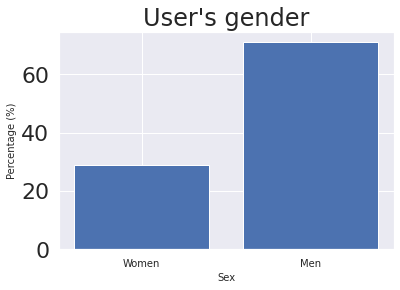

In [ ]:
utl.barplot(['Women', 'Men'], np.array([np.mean(gender) , 1 - np.mean(gender)]) * 100, 
            'Sex', 'Percentage (%)', "User's gender", 0)

#### Percentage of users per <i>occupation.

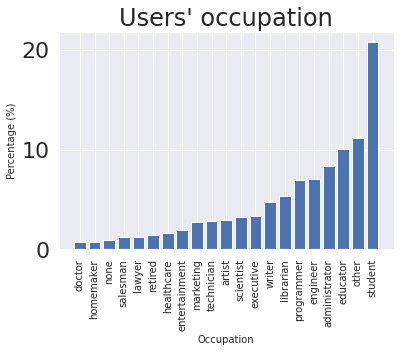

In [ ]:
attributes, scores = utl.rearrange(occupation_name, np.mean(occupation_matrix, axis=0) * 100)
utl.barplot(attributes, scores, 'Occupation', 'Percentage (%)', "Users' occupation", 90)

### 1.3.2 Movies: Download and preprocesssing

In the same way, we process and explore the data associated with the movies. For each movie, we have the title, the release date in North America, as well as the genres with which it is associated.

In [ ]:
movies = pd.read_csv(os.path.join(DATA_DIR, 'u.item'), sep='|', header=None, engine='python', encoding='latin-1')

# Number of movies
nb_movies = len(movies)

# Genres
movies_genre = np.matrix(movies.loc[:, 5:])
movies_genre_name = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u.genre'), sep='|', header=None, engine='python', encoding='latin-1').loc[:, 0])

# Quick overview
movies.columns = ['Index', 'Title', 'Release', 'The Not a Number column', 'Imdb'] + movies_genre_name.tolist()
movies.head()

,Index,Title,Release,The Not a Number column,Imdb,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


We present the ratio of movies according to the genre as a descriptive statistic.

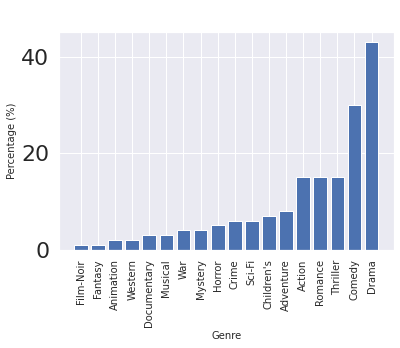

In [ ]:
attributes, scores = utl.rearrange(movies_genre_name, 
                                   np.array(np.round(np.mean(movies_genre, axis=0) * 1, 2))[0])
utl.barplot(attributes, np.array(scores) * 100, xlabel='Genre', ylabel='Percentage (%)', 
            title=" ", rotation = 90)

### 1.3.3 Ratings: Download and preprocessing

The dataset based on users ratings consists of approximately 100k lines (one evaluation per line) where the following are presented: the user identification number, the identification number of the movie, its associated rating and a time marker. The training and test sets were provided as is, that is, we do not need to build them ourselves, and have 80k and 20k evaluations respectively.

For practical reasons, we convert the database as a list using the `convert` house function.

In [ ]:
training_set = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u1.base'), delimiter='\t'), dtype='int')
testing_set = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u1.test'), delimiter='\t'), dtype='int')

print('Example sample (user idx, movie idx, rating, timestamp: ', training_set[0])
print('Shape of original training and test set with shape:     ', training_set.shape, testing_set.shape)


Example sample (user idx, movie idx, rating, timestamp:  [        1         2         3 876893171]
Shape of original training and test set with shape:      (79999, 4) (19999, 4)


In [ ]:
train_set = utl.convert(training_set, nb_users, nb_movies)
test_set = utl.convert(testing_set, nb_users, nb_movies)

print('Shape of final training set: (list of users x list of all movies):', len(train_set), len(train_set[0]))
print('Shape of final test set:     (list of users x list of all movies):', len(test_set), len(test_set[0]))


Shape of final training set: (list of users x list of all movies): 943 1682
Shape of final test set:     (list of users x list of all movies): 943 1682


As we did before, we can get descriptive statistics associated with the evaluations. At first, it might be interesting to study the average trends of users.

##### Question 1

1. What other types of statistics might be interesting?

In [ ]:
train_matrix = np.array(train_set)
shape = (len(train_set), len(train_set[0]))
train_matrix.reshape(shape)
train_matrix_bool = np.where(train_matrix > 0 , 1, 0)

user_watch = np.sum(train_matrix_bool, axis=1)
pd.DataFrame(user_watch).describe().T

,count,mean,std,min,25%,50%,75%,max
0,943.0,84.834571,83.805787,4.0,27.0,50.0,115.0,685.0


Histogram of the number of movies watched per user.

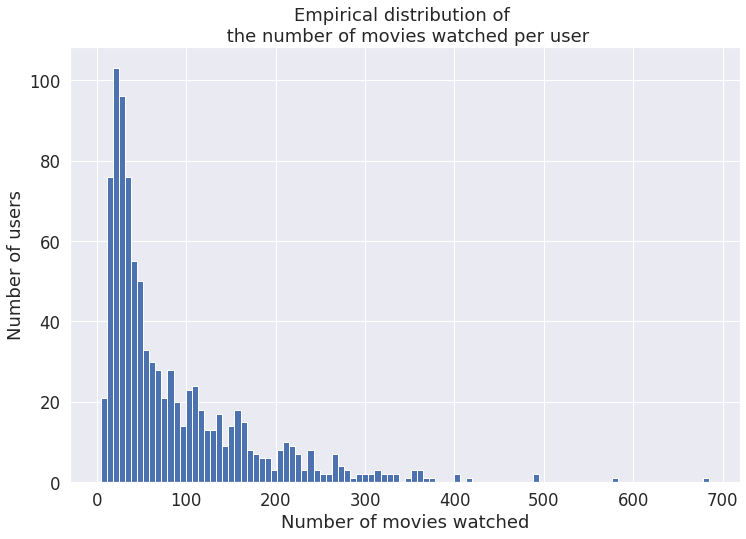

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.title('Empirical distribution of \n the number of movies watched per user')
plt.xlabel('Number of movies watched')
plt.ylabel('Number of users')
plt.hist(user_watch, 100);

Descriptive statistics related to the movies' evaluation.

In [ ]:
movie_frequency = np.mean(train_matrix_bool, axis=0)
pd.DataFrame(movie_frequency).describe().T

,count,mean,std,min,25%,50%,75%,max
0,1682.0,0.050437,0.068664,0.0,0.005302,0.022269,0.066808,0.513256


##### Question 2

1. What statistics or observations might we consider relevant? Why?
2. What kind of statistics might be more appropriate in such a context?

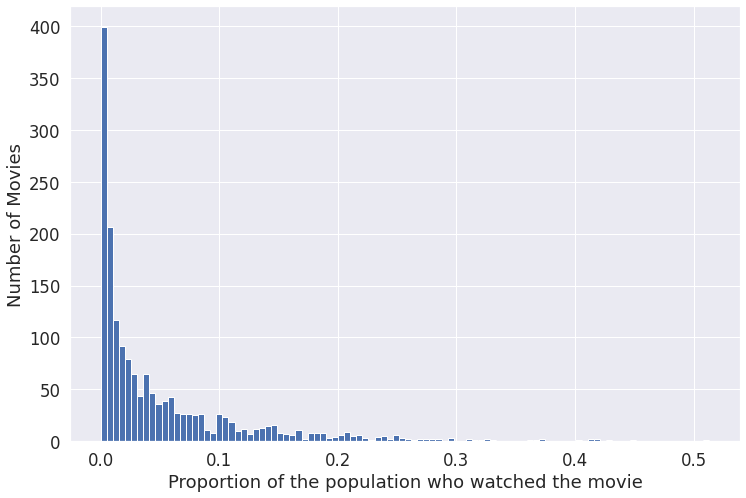

In [ ]:
plt.xlabel('Proportion of the population who watched the movie')
plt.ylabel('Number of Movies')
plt.hist(movie_frequency, 100);

#### Individual preferences according to the type of movie

We could also look at the behavior of a particular individual. Among other things, we could study if there is a bias associated with her evaluation scheme or what are her cinematographic preferences according to the score awarded.

In [ ]:
def stats_user(data, movies_genre, user_id):
    
    ratings = data[user_id]
    stats = np.zeros(6)
    eva = np.zeros((6, movies_genre.shape[1]))

    for k in np.arange(len(ratings)):
        index = int(ratings[k])
        stats[index] += 1
        eva[index, :] = eva[index, :] + movies_genre[k]

    return stats, eva

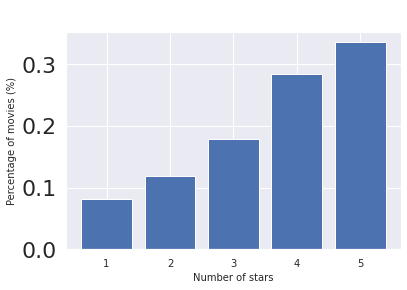

In [ ]:
user_id = 0
stats, eva = stats_user(train_set, movies_genre, user_id)
utl.barplot(np.arange(5) + 1, stats[1:6] / sum(stats[1:6]), xlabel='Number of stars', ylabel='Percentage of movies (%)', 
            title=" ", rotation = 0)

##### Question 3

1. How can we test to the existence of bias associated to individual's assessment scheme?

## 1.4 Construction of the training and validation sets

In machine learning, we manipulate <a href="https://blogs.nvidia.com/blog/2018/04/15/nvidia-research-image-translation/">complex databases</a> for which we attempt to define equally complex function spaces in order to accomplish a specific task. That being said, these function spaces are defined by a set of parameters whose number tends to increase with the complexity of the data. Once space is defined by a set of fixed parameters, we can vary the different values of the hyperparameters in order to empirically explore function spaces. To choose the set of optimal parameters and hyperparameters, we define a metric that allows us to evaluate the model; for example, how much the image of a cat seems likely.

To the extent that we want to develop a model that can generalize, the evaluation of its performance must be done on an independent dataset, coming from the same distribution from the set on which the model was trained. This set is called the validation set.

<b>! Note! </b>

The notion of training and test set in the framework of recommender systems is somewhat different from what is usually seen with so-called supervised problems. If in the context of a supervised problem, the test set consists essentially of new observations (lines from a file) which are independent of observations previously observed in the training set. The paradigm is significantly different when we work with recommendation systems.

Indeed, because of the mathematical model on which the recommendation systems are based, the data belonging to the test set are not linked to a new individual, but rather to new evaluations made by the same set of individuals. As a result, the data associated with the training, validation and test sets are no longer independent as assumed (the famous <i>iid</i> hypothesis) which complicates things theoretically.

Since the purpose of the workshop is not to study the notion of bias associated with the type of dependence between the different assessments in referral systems, we will naively assume that each of the assessments is independent of each other. Nevertheless, in a practical framework, ignoring this kind of considerations will possibly bias the algorithms.

In [ ]:
def split(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] > 0:
                if np.random.binomial(1, ratio, 1):
                    train[i][j] = data[i][j]
                else:
                    valid[i][j] = data[i][j]

    return [train, valid]

train = split(train_set, 0.8)
test = test_set

# 2. Recommender systems: Matrix Factorization

## 2.1 Model

Matrix factorization (MF) supposes that each observed evaluation $r_{ui}$ for $1 \leq u \leq |U|$ and $1 \leq i \leq |I|$, where $|U|$ and $|I|$ are respectively the number of users and movies, can be estimated with respect to a latent (hidden) model. This model presents the estimate $\hat{r}_{ui}$ of the observed evaluation $r_{ui}$ as:


$$
\begin{align}
\hat{r}_{ui} =  \langle p_{u}, q_{i} \rangle, 
\end{align}
$$

where $\langle \cdot \rangle$ is the scalar product and $p_{u}$ et $q_{i}$ are the latent representations associated to user <i>u</i> and item <i>i</i>. The intuition behind this representation suggests that each evaluation can be estimated by considering a latent characterization of users and items.

For example, let's fix the number of latent variables to 3, and suppose that they are associated with the popularity of the movie at the box office, its duration and finally its level of romance. Let us define the <i>u</i> user as a 15-year-old teenager who loves popular and relatively short horror movies. We can model the associated latent vector by:
$$
\begin{align}
p_{u} = [1, 0, 0]^T.
\end{align}
$$

Suppose now that the movie <i>i</i> turns out to be <i>The Lion King</i> with the following latent modelization:

$$
\begin{align}
q_{i} = [1, 0.5, 0]^T.
\end{align}
$$

The estimation of the evaluation for this user and item according to the latent representations will therefore be:

$$
\begin{align}
\hat{r}_{ui} =  \langle p_u, q_i \rangle = 1.
\end{align}
$$

The main challenge in this type of model is to define the set of latent vectors associated with users, grouped in matrix form by $\mathbf{P}_{|U| \times k} = [p_1, p_2, .. ., p_k]$, and to items, grouped in matrix form by $ \mathbf{Q}_{|I| \times k} = [q_1, q_2, ..., q_k] $.
 
Since the initial problem is to present the most accurate estimates, and thus to calculate $\mathbf{P}$ and $\mathbf{Q}$ so as to minimize the distance between the totality of the observed ratings $r_{ui}$ and their estimate $\hat {r}_{ui}$, we can define the task to accomplish with the following optimization problem:

$$
\begin{align}
\mathbf{P}, \mathbf{Q} = \underset{p, q}{\operatorname{argmin}} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2 = \underset{p, q}{\operatorname{argmin}}  \sum_{r_{ui} \neq 0} (r_{ui} - \langle p_u, q_i \rangle)^2.
\end{align}
$$

We may add a regularization on the latent variables, in order to force the associated vectors to have non-zero components:

$$
\begin{align}
\mathbf{P}, \mathbf{Q} = \underset{p, q}{\operatorname{argmin}} \sum_{r_{ui} \neq 0} \{(r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda(||p_u||^2 + ||q_i||^2)\},
\end{align}
$$

where $\lambda$ is the regularization hyperparameter, <i>weigth decay</i> in deep learning, or Lagrange multiplier in math. Although this last remark seems technical, it should be noted that latent vectors with very few zero values will in turn lead to predicted ratings other than zero. Since we are trying to propose new recommendations, this constraint seems useful to avoid a sparse matrix estimate $\hat{\mathbf{R}}$.

In general, the optimization problem above, which turns out to factorize a sparse matrix, cannot be solved as easily as using the least squares in a linear regression context for example. One method will be introduced in this tutorial to estimate $\mathbf{P}$ and $ \mathbf{Q}$ matrices.

## 2.2 Implementation

In order to build a recommendation system based on MF, we have to define some specific functions necessary for this type of algorithm. Overall, we can describe the matrix factorization algorithm in three steps:

1. <b>Learning loop</b>: Review each of the evaluations in a loop until the estimated model varies only slightly from one iteration to another based on a chosen criterion.

2. <b> Estimation</b>: Estimation of the matrices of factors $\mathbf{P}$ and $\mathbf{Q}$ respectively associated with the users and the items.

3. <b> Evaluation</b>: Evaluation of the performance of the model according to a chosen metric.


### 2.2.1 Learning loop

The function consists simply in iterating the various evaluations until a given stopping criterion is respected.



##### Question 4

1. Given estimators obtained via stochastic gradient descent (SGD), what condition should we add to line 31? Why?
2. At the end of each epoch, which statistic would it be better to calculate? Code it. Now. Note: Do not forget to initialize objects at the beginning of the function.
3. Give two reasons why these statistics are useful.
4. The stopping criterion for avoiding overfitting on line 45 is rather stupid. Why?
5. Develop a new stopping criterion.

In [ ]:
def learn_to_recommend(data, features=10, lr=0.0002, epochs=101, weigth_decay=0.02, stopping=0.001):
    """
    Args:
       data: every evaluation
       features: number of latent variables
       lr: learning rate for gradient descent
       epochs: number of iterations or maximum loops to perform
       weigth_decay: L2 regularization to predict rattings different of 0
       stopping: scalar associated with the stopping criterion
      
     Returns:
       P: latent matrix of users
       Q: latent matrix of items
       loss_train: vector of the different values of the loss function after each iteration on the train
       loss_valid: vector of the different values of the loss function after each iteration not on valid
       """
     
    train, valid = data[0], data[1]
    nb_users, nb_items = len(train), len(train[0])

    # Question 4.2: Initialization of lists
    # loss_train, loss_valid = [], []

    
    P = np.random.rand(nb_users, features) * 0.1
    Q = np.random.rand(nb_items, features) * 0.1
    
    for k in range(epochs):        
        for i in range(nb_users):
            for j in range(nb_items):

                # Question 4.1: Code the condition
                # if ...
                    eij = train[i][j] - prediction(P, Q, i, j)
                    P, Q = sgd(eij, P, Q, i, j, features, lr)
                               
        # Question 4.2: Code the statistics
        #
        #
        
        if k % 10 == 0:
            print('Epoch : ', "{:3.0f}".format(k+1), ' | Train :', "{:3.3f}".format(loss_train[-1]), 
                  ' | Valid :', "{:3.3f}".format(loss_valid[-1]))

        # Question 4.4: Goofy stopping criterion
        if abs(loss_train[-1]) < stopping:
            break
            
        # Question 4.5 : New stopping criterion
        # if ... :
            break
        
    return P, Q, loss_train, loss_valid

### 2.2.2 Loss function

The loss function plays a decisive role in the construction of a predictive model. In fact, it is this same cost function that we will try to optimize by iteratively adjusting the values of the latent matrices $\mathbf{P}$ and $\mathbf{Q}$.

Since we consider that the observed evaluations vary between 1 and 5, the mean squared error (MSE) seems an interesting first option. From a recommender system point of view, we will define the MSE as follows:

$$
\begin{align}
MSE(\mathbf{R}, \hat{\mathbf{R}}) = \frac{1}{n} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2, 
\end{align}
$$

where $\mathbf{R}$ and $\hat{\mathbf{R}}$ are respectively the matrices of observed and predicted ratings <i>n</i> is the sum of estimated evaluations.



##### Question 5

1. Suppose we want to predict the evaluation of user <i>i</i> for the movie <i> j </i>, how should do it? Implement the prediction function.
2. An important detail is missing in the following `loss` function. How is this error fundamental? Correct it.

In [ ]:
# Question 5.1:
def prediction(P, Q, i, j):
    """
    Args:
        P: user matrix
        Q: matrix of items
        i: index associated with the user i
        j: index associated with item j
    Returns:
        pred: the predicted evaluation of the user i for the item j
    """
    return ?

def loss(data, P, Q):
    """
    Args:
       data: ratings
       P: matrix of users
       Q: matrix of items   
    Returns:
        MSE: observed mean of squared errors 
    """
    errors_sum, nb_evaluations = 0., 0

    for i in range(len(data)):
        for j in range(len(data[i])):
            
            # Question 5.2:
            #
                errors_sum += pow(data[i][j] - prediction(P, Q, i, j), 2)
                nb_evaluations += 1
                
    return errors_sum / nb_evaluations

### 2.2.3 Estimation

Parameters' estimates are directly associated with the loss function we are trying to minimize. With matrix factorization, two estimation techniques are available to calculate latent matrices $\mathbf{P}$ and $\mathbf{Q}$ respectively associated to users and items. In both cases, these techniques use the linearity of the matrix factorization model.

#### Gradient descent

First, we implement stochastic gradient descent (SGD); an iterative method that reviews all non-zero evaluations for each user. Formally, and remembering that the function we are trying to minimize is:

$$
\begin{align}
\underset{p, q}{\operatorname{min}} L(\mathbf{R}, \lambda) = \underset{p, q}{\operatorname{min}} \sum_{r_{ui} \neq 0} \{(r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda \cdot (||p_u||^2 + ||q_i||^2)\},
\end{align}
$$

we calculate the gradients of the previous equation as a function of $p_u$ and $q_i$:

$$
\nabla_{p_{u}} L(\mathbf{R}, \lambda) =  \epsilon_{ui} \cdot q_{i} - \lambda \cdot p_{u} \quad \text{et} \quad 
\nabla_{q_{i}} L(\mathbf{R}, \lambda) =  \epsilon_{ui} \cdot p_{u} - \lambda \cdot q_{i},
$$

where:

$$
\epsilon_{ui} = r_{ui} - \hat{r}_{ui}. 
$$

Finally, for each iteration, and insofar as the evaluation observed is non-zero, each update of the latent vectors can be done as follows:

$$
p_{u}^{(t+1)} \leftarrow p_{u}^{(t)} + \gamma \cdot (\epsilon_{ui} \cdot q_{i}^{(t)} - \lambda \cdot p_{u}^{(t)}) \\
q_{i}^{(t+1)} \leftarrow q_{i}^{(t)} + \gamma \cdot (\epsilon_{ui} \cdot p_{u}^{(t)} - \lambda \cdot q_{i}^{(t)}),
$$

where $ p_{u}^{(t + 1)}$ is the value of $ p_{u}$ after the $t + 1$ iteration and where $\gamma$ is the learning rate of the descent.

#### Note on alternate least squares

The second technique is based on Alternate Least Squares (ALS). This method is elegant in that it allows an analytical form. We will not implement it in this workshop.



##### Question 6

1. Considering the equations associated with the descent of the gradient, complete the `sgd` function to implement the stochastic descent gradient.

In [ ]:
def sgd(error, P, Q, id_user, id_item, features, lr):
    """
    Args:
        error: difference between observed and predicted evaluation (in that order)
        P: matrix of users
        Q: matrix of items
        id_user: id_user
        id_item: id_item
        features: number of latent variables
        lr: learning for the descent of the gradient
       
     Returns:
         P: the new estimate of P
         Q: the new estimate of Q
         """    
    
    # Answer 6.1 :
    return P, Q

## 2.3 Training

Now that matrix factorization is implemented, we can begin to train the model with different parameters and hyperparameters. The idea here is not to adjust the parameters in such a way as to obtain the best model, but simply to understand the role that they can play, both from the point of view of overfitting and computing time. In fact, there are very few wrong answers.

In [ ]:
features = 5
lr = 0.02
epochs = 101
weigth_decay = 0.02
stopping = 0.01

P, Q, loss_train, loss_valid = learn_to_recommend(train, features, lr, epochs, weigth_decay, stopping)

Once the model is trained, we can visualize the different learning curves.

In [ ]:
x = list(range(len(loss_train)))
k=0

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.plot(x[-k:], loss_train[-k:], 'r', label="Train")
plt.plot(x[-k:], loss_valid[-k:], 'g', label="Validation")
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
leg = plt.legend(loc='best', shadow=True, fancybox=True)

##### Question 7

1. Was it necessary to iterate that much?
2. Based on these curves, which stopping criterion could we develop?
3. How is it more relevant than the one defined in the learning loop?
4. Implement it.

Finally, we can evaluate the performance of our model on the test set.

##### Question 8

1. Implement the procedure.
2. How is it relevant to evaluate performance on such a set?

In [ ]:
# Question 8.1


## 2.4 Analysis

**! Note !**

Although this section is particularly interesting, you can go directly to Section 3 for a closer look at the algorithmic side of a recommendation. You will be able to return to this section once the matrix factorization workshop has been completed.

### 2.4.1 Exploring latent layers

Thanks to matrix factorization, it is possible to explore the various latent variables associated with users and items. By the nature of the matrices $\mathbf{P}$ and $\mathbf{Q}$, the exploration of <i>k</i> latent variables associated with the columns of $\mathbf{P}$ and $\mathbf{Q}$ might be interesting.

For example, suppose that the first two latent variables in the array of $\mathbf{Q}$ objects have the following values:

$$
\begin{align}
q_1 &= [-1.0, \ -0.8, \ 0.0, \ ..., \ 1.0, \ 0.5]
\qquad \text {and} \qquad
q_2 = [-1.0, \ 0.8, \ 1.0, \ ..., \ 0.5, \ -0.8].
\end{align}
$$

Finally, suppose that these values correspond to the following movies:

1. The Room (2003),
2. Star Wars: Attack of the clones (2002),
3. Titanic (1997),
4. Citizen Kane (1954),
5. The Nigthmare before Christmass (1993).

By mapping these movies according to the associated values ​​of the first two latent variables, we obtain the following graph:

<img src = "../Images/hidden.png" width = "500">

After a quick glance, we can see that the first latent variable is associated with the critical reception of the movie, while the second variable detects the presence of a superstar. If this first analysis may seem interesting to us, but any, it will make more sense once coupled with the values associated with the matrix of users $ \mathbf{P}$. Suppose now that the first two latent variables of the $\mathbf{P}$ user matrix have the following values:

$$
\begin{align}
p_1 &= [1.0, \ 0.0, \ -0.5, \ ..., \ 1.0, \ -1.0]
\qquad \text{and} \qquad
p_2 = [1.0, \ 0.0, \ 0.5, \ ..., \ -1.0, \ -0.8].
\end{align}
$$

And that to these values correspond the following users:

1. Serena,
2. Kali,
3. Neil,
4. Mary,
5. David.

We will then be able to map the users according to the values associated with $ p_1 $ and $ p_2 $ while preserving the characterization of the axes that we obtained before:

<img src = "../Images/hidden_2.png" width = "500">

This approach could allow us to suggest new movies that have never been evaluated by users simply based on certain characteristics. For example, there is a good chance that Serena loves the upcoming Scorsese <i> The Irish man </i> movie and that Neil looks forward to the new <i> Cat </i>.

We therefore propose a function facilitating the exploration of latent variables. Considering the comment related to the viewing frequency of movies in Section 1.4.3, we will only focus on movies with a viewing frequency above a chosen threshold.

In [ ]:
def exploration(object_name, matrix, freq, factor, k):
    """
    Args:
        object_name: vector of movie names
        matrix: latent matrix associated with movies
        freq: minimum viewing frequency beyond which we can consider the movie in the analysis
        factor: the number of the latent variable that we want to study
        k: number of output movies = 3 * k - 1
       
    Returns:
         names: the title of the movies
         scores: the associated predicted evaluation
         """
    
    values = matrix[:, factor] * freq
    names, scores = utl.rearrange(object_name, values)
    nonzero = np.nonzero(scores)
    
    start = nonzero[0][0]    
    center = int((len(object_name) - start) / 2)
    
    names = names[start: (start+k) ] + names[(start+center - 1):(start+ center + 2)] + names[-k:]
    scores = scores[start : (start+k) ] + scores[(start+center - 1):(start+ center + 2)] + scores[-k:]
    
    return names, scores

We call the function and visualize the results.

##### Question 9

1. Can some latent variables be interpretable?
2. What would happen if we increase the number of latent variables? If we decrease it?

In [ ]:
k = 2
factor = 0
threshold = 0.1
names, scores = exploration(movies['Title'], Q, np.where(movie_frequency > threshold, 1, 0), factor, k)

df = pd.DataFrame(np.matrix((names, scores)).T, (np.arange(len(scores)) + 1).tolist())
df.columns = ['Title', 'Latent factor']
df

# 3. Applications 

One of the primary objectives of the recommendation systems is to make personalized recommendations (!) Therefore, it might be interesting to study the recommendations made by the model for a particular user. Naturally, the recommendations made only suggest movies unseen by the user.

##### Question 10

1. We will now, for a chosen user, make the 10 best recommendations associated with her preferences. Hence, we will proceed in simple steps as presented in the code. Note that the `rearrange` house function presented below may be helpful.

In [ ]:
"""
Example:
a, b = ['a', 'b', 'c'], [6,1,3]
a, b = rearrange(a, b)
print("a:", a, " b:", b)
"a:[b, c, a] b:[1,2,6]"
"""

def rearrange(names, ratings):
    attribute, scores = [], []
    ranking = np.argsort(ratings)

    for k in np.arange(len(ranking)):
        attribute.append(names[ranking[k]])
        scores.append(ratings[ranking[k]])

    return attribute, scores

In [ ]:
user_id = 0
top_what = 10

# Step 1: Define which movies have already been viewed in each of the subsets

# Step 2: Map the predicted set of ratings for the selected individual

# Step 3: Consider only assessments associated with training and validation sets

# Step 4: Sort the estimates on the different sets so as to propose the best 10 recommendations

# Recommendations


It could be interesting to recommend movies to the user according to her preferences but also depending on the genre.

##### Question 11

1. Write a function to perform such a task.

In [ ]:
def recommendations(user_id, data, P, Q, movies_genre, genre, new):
    """
    args:
        user_id: user_id
        data: all assessments
        P: matrix of individuals
        Q: item matrices
        movies_genre: kind of movie user wants to listen to
        new: Boolean, do we want to make new recommendations or not?
    
     Returns:
        the best suggestions based on the genre of movie selected
     """
    
    # ...
    
    return np.array(predictions) * np.array(genre.T)[0]

In [ ]:
genre = "Animation"
top_what = 5

# Calculation and reorganization of recommendations
estimate = recommendations(user_id, train, P, Q, movies_genre, genre, False)
suggestions, scores = rearrange(np.array(movies['Title']), estimate)

# Presentation
df = pd.DataFrame(np.matrix((suggestions[-top_what:], scores[-top_what:])).T, (np.arange(top_what) + 1).tolist())
df.columns = ['Title', 'Predicted rating']
df